In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import glob, os

In [4]:
i=0
# os.chdir("streetnr/newdata/test")
for file in glob.glob("data/test/*.png"):
    i +=1
    
print(i,file)

13068 data/test/image9601_344xx.png


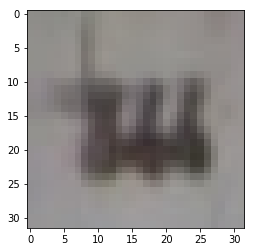

In [5]:
from skimage import io, transform

def im_show(image):
    plt.imshow(image)
    plt.show()
    
im_show(io.imread(os.path.join(file)))

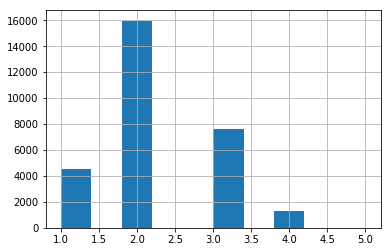

In [13]:
def make_csv(dir,files):
    f_dir = os.path.join(dir,files,"*.png")
    pics = []
    for file in glob.glob(f_dir):
        y = []
        num=0
        for i in (file.split("_")[1].split(".png")[0]):
            if i is not "x":
                y.append(int(i))
                num+=1
            else:
                y.append(10)
        pics.append({"filename":file,"y":y,"number":num})
    df = pd.DataFrame(pics)
    df.to_csv(os.path.join(dir,files +"_data.csv"))
    return df
    
    
make_csv('data','test')    

make_csv('data','valid')    
df = make_csv('data','train')    
df.number.hist()

In [56]:

from torch.utils.data import Dataset, DataLoader

class HouseNumbersDataset(Dataset):

    def __init__(self, csv_file,  transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.df = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 1]
        image = io.imread(img_name).transpose([2,0,1])
        print(image.shape)#,image
        sample = {'image': image, 'y': self.df.iloc[idx, 3]}

        if self.transform:
            sample = self.transform(sample)

        return sample


(3, 32, 32)
0 (3, 32, 32) [1, 9, 5, 10, 10]


TypeError: Invalid dimensions for image data

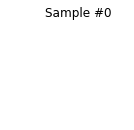

In [57]:
face_dataset = HouseNumbersDataset(csv_file='data/test_data.csv')

fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]

    print(i, sample['image'].shape, sample['y'])

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    im_show(sample['image'])

    if i == 3:
        plt.show()
        break

In [58]:
from fastai import DataBunch
train_ds = HouseNumbersDataset(csv_file='data/train_data.csv')
train_dl = DataLoader(train_ds, batch_size = 16, shuffle=True)
val_dl = DataLoader(HouseNumbersDataset(csv_file='data/valid_data.csv'), batch_size = 16, shuffle=True)
test_dl = DataLoader(HouseNumbersDataset(csv_file='data/test_data.csv'), batch_size = 16, shuffle=True)

df =pd.concat([pd.read_csv('data/valid_data.csv'),pd.read_csv('data/train_data.csv')])
df.to_csv('data/fix_data.csv')
fix_dl = DataLoader(HouseNumbersDataset(csv_file='data/fix_data.csv'), batch_size = 16, shuffle=True)
md = DataBunch(train_dl, val_dl, fix_dl=fix_dl, test_dl=test_dl)

AttributeError: 'HouseNumbersDataset' object has no attribute 'items'

In [70]:
from torchvision import models, transforms

class VanillaResNet(torch.nn.Module):
    def __init__(self,out):
        
        super(VanillaResNet, self).__init__()
        self.model_conv = models.resnet18(pretrained=True ).eval()
        for param in self.model_conv.parameters():
            param.requires_grad = False
#         del self.model_conv.fc
        self.fc = torch.nn.Linear(512+1, out)
        
    def forward(self, x,num):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        x=self.model_conv(x)
        print(x.shape)
        x=torch.cat([x,num])
        return self.fc(x)
    
class FiveTimesRes(torch.nn.Module):
    def __init__(self):
        super(FiveTimesRes, self).__init__()
        self.res=VanillaResNet(11)
        
    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        y=[]
        for i in range(5):
            y.append(self.res(x,torch.tensor(i)))
        return y

def test_res():
    
    mdl = FiveTimesRes()
    im = torch.tensor(train_ds[0]["image"])[None,:,:,:].float()
    models.resnet18(pretrained=True ).eval()(im)
    print(im.shape)
    print(mdl(im))
test_res()

(3, 32, 32)


RuntimeError: Given input size: (512x1x1). Calculated output size: (512x-5x-5). Output size is too small at /pytorch/aten/src/THNN/generic/SpatialAveragePooling.c:48

In [27]:
model_conv.fc=None

In [49]:
model_conv = models.resnet18(pretrained=True )

In [50]:
model_conv 

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co